## TODO:
2. create united dict of SNR & weather - dict format:
*   { date : [
        temp
        wind
        umidity
        freq - constant due to only one staellite 
        dist - constant due to only one staellite
        angle - constant due to only one staellite
        SNR
      ]
    }
3. adjust input size of network
4. normalize input date

## Uploading files for google colab

In [0]:
#############################################
#                                           #
# Written by Nitzan Zisman & Gev Blau       #
#                                           #
#############################################

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# adjust SNR data to weather data (sample each 5 min)

In [0]:
#############################################
#                                           #
# Written by Nitzan Zisman & Gev Blau       #
#                                           #
#############################################

import glob, os


SNR_all_lines = []
for filename in glob.glob('/content/drive/My Drive/Colab_Notebooks/SNR/*'):
  with open(filename, 'r') as file:
    SNR_lines = file.readlines()
  SNR_lines = SNR_lines[0:len(SNR_lines)-1:2]
  SNR_all_lines.extend(SNR_lines)

start_min = 0
start_hour = int(SNR_all_lines[0].split(',')[1][11:13])
avg_snr = 0
line_counter = 0
SNR_5min = []
new_snr_line = SNR_all_lines[0]
for line in SNR_all_lines:
  if (int(line.split(',')[1][14:16]) < start_min + 5) and (int(line.split(',')[1][11:13]) == start_hour):
    avg_snr += float(line.split(',')[0].strip())
    line_counter += 1
  else:
    if (line_counter == 0):
      start_min = int(line.split(',')[1][14:16])
      start_hour = int(line.split(',')[1][11:13])
      continue
    
    avg_snr /= line_counter
    snr_data = str(avg_snr)
    date = new_snr_line.split(',')[1][0:14]
    date += str(start_min).zfill(2)
    date += ":00"
    new_snr_line = snr_data + ' ' + date
    SNR_5min.append(new_snr_line)
    avg_snr = 0
    line_counter = 0
    new_snr_line = line
    start_min = (start_min + 5) % 60
    if (start_min == 0):
      start_hour = (start_hour + 1) % 24

with open('/content/drive/My Drive/Colab_Notebooks/SNR_5min', '+w') as write_file:
  for line in SNR_5min:
    write_file.write("%s\n" % line)

In [0]:
#############################################
#                                           #
# Written by Nitzan Zisman & Gev Blau       #
#                                           #
#############################################
import csv
import math

from datetime import datetime

AMOS_7_FREQ = 11113;
PETAH_TIKVA_AMOS_7_DIST = 40000;
PETAH_TIKVA_AMOS_7_ANGLE = math.asin(36000/PETAH_TIKVA_AMOS_7_DIST)/math.pi*180;

def update_ranges(values_ranges, line_data):
  for cell_index, cell in enumerate(line_data):
    if cell < values_ranges[cell_index][0]:
      values_ranges[cell_index][0] = cell
    if cell > values_ranges[cell_index][1]:
      values_ranges[cell_index][1] = cell 


with open('/content/drive/My Drive/Colab_Notebooks/SNR_5min', 'r') as SNR_file:
  SNR_lines = SNR_file.readlines()

weather_lines = []
with open('/content/drive/My Drive/Colab_Notebooks/weather data/03-2020.csv', 'r') as weather_file:
  weather_lines_reader = csv.reader(weather_file)
  for row in weather_lines_reader:
    weather_lines.append(row)
  # weather_lines_reader = list(weather_lines_reader)
  # weather_lines_count = sum(1 for row in weather_lines_reader)

SNR_index = 0
weather_index = 1
network_input = {}
SNR_lines_count = len(SNR_lines)
weather_lines_count = len(weather_lines)

values_ranges = [[float(weather_lines[0][2]), float(weather_lines[0][2])], 
                 [float(weather_lines[0][3]), float(weather_lines[0][3])], 
                 [float(weather_lines[0][4]), float(weather_lines[0][4])], 
                 [AMOS_7_FREQ, AMOS_7_FREQ], 
                 [PETAH_TIKVA_AMOS_7_DIST, PETAH_TIKVA_AMOS_7_DIST], 
                 [PETAH_TIKVA_AMOS_7_ANGLE, PETAH_TIKVA_AMOS_7_ANGLE],
                 [float(SNR_lines[0].split(' ')[0]), float(SNR_lines[0].split(' ')[0])]]

while SNR_index < SNR_lines_count - 1 and weather_index < weather_lines_count - 1:
  SNR_line = SNR_lines[SNR_index]
  weather_line = weather_lines[weather_index]
  if '-' in weather_line:
    weather_index += 1
    continue
  str_datetime_SNR = SNR_line.split(' ')[1] + ' ' + SNR_line.split(' ')[2][:-1]
  str_datetime_weather = weather_line[0] + ' ' + weather_line[1] + ':00'
  datetime_SNR_line = datetime.strptime(str_datetime_SNR, '%Y-%m-%d %H:%M:%S')
  if '-' in str_datetime_weather:
    datetime_weather_line = datetime.strptime(str_datetime_weather, '%d-%m-%Y %H:%M:%S')
  else:
    datetime_weather_line = datetime.strptime(str_datetime_weather, '%d/%m/%Y %H:%M:%S')
  
  if datetime_SNR_line == datetime_weather_line:
    network_input[datetime_SNR_line.strftime('%Y/%m/%d %H:%M:%S')] = [float(weather_line[2]), float(weather_line[3]), float(weather_line[4]), 
                                                                      AMOS_7_FREQ, PETAH_TIKVA_AMOS_7_DIST, PETAH_TIKVA_AMOS_7_ANGLE, 
                                                                      float(SNR_line.split(' ')[0])]
    update_ranges(values_ranges, network_input.get(datetime_SNR_line.strftime('%Y/%m/%d %H:%M:%S')))
    weather_index += 1
    SNR_index += 1
  if datetime_SNR_line > datetime_weather_line:
    weather_index += 1
  if datetime_SNR_line < datetime_weather_line:
    SNR_index += 1

for key, val in network_input.items():
  for cell_index, cell in enumerate(val):
    if values_ranges[cell_index][1] == values_ranges[cell_index][0]:
      network_input[key][cell_index] = 1
    else:
     network_input[key][cell_index] = (cell - values_ranges[cell_index][0]) / (values_ranges[cell_index][1] - values_ranges[cell_index][0])  

# with open('/content/drive/My Drive/Colab_Notebooks/network_input_file', "w+") as network_input_file:
#   for item in network_input:
#     network_input_file.write("".format(item))

print(len(network_input))
for key, value in network_input.items():
  print(f"datetime = {key}, data = {value}")

# RNN Network

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 3, 10)             70        
_________________________________________________________________
lstm_29 (LSTM)               (None, 60)                17040     
_________________________________________________________________
dense_86 (Dense)             (None, 10)                610       
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 11        
Total params: 17,731
Trainable params: 17,731
Non-trainable params: 0
_________________________________________________________________
Train on 6380 samples, validate on 1593 samples
Epoch 1/50
6380/6380 [==============================] - 3s 419us/step - loss: 0.1224 - mean_absolute_error: 0.2375 - val_loss: 0.0039 - val_mean_absolute_error: 0.0490
Epoch 2/50
6380/6380 [=========

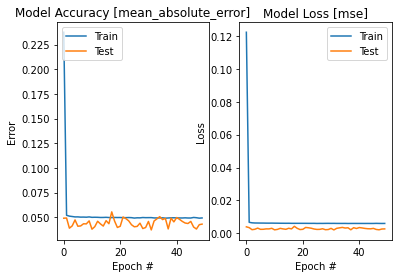

In [0]:
#############################################
#                                           #
# Written by Nitzan Zisman & Gev Blau       #
#                                           #
#############################################
from google.colab import files

## for code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json, time
import ast
from datetime import date

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.models import load_model

INPUTS_NUM = 7
TIME_STEP = 3
TRAIN_TEST_RATIO = 0.8
BATCH_SIZE = 15
NUM_OF_EPOCHS = 50

# old stuff
BATACH_SIZE_old = 16
loss_function = ""
metric = ""

# def preprocess_data():
#     return network_input
def preprocess_data(network_input):
    """
    This function will pre-process the data to fit as a normalized input for the neural network.
    :param data_paths: list containing paths to the json files containing the input data and the labeled results.
    :return: a dictionary containing the normalized data.
    """
    data_list = []          # will hold the processed data


    with open('/content/drive/My Drive/Colab_Notebooks/network_input_file', "w+") as preprocessed_file:
      for key, value_data_list in network_input.items():
        info = value_data_list[0:7]
        # print(f"a {info}")
        data_list.append(info)
        preprocessed_file.write(f"{info}\n")

          # for date_key in cur_data[main_key]:
          #     for hour_key in cur_data[main_key][date_key]:
          #         info = cur_data[main_key][date_key][hour_key]
          #         for idx in range(len(info)):
          #             # data normalization
          #             if idx < len(info) - 4:
          #                 range_tup = ranges["{0}".format(idx)]
          #                 info[idx] = (float(info[idx]) - range_tup[0]) / (range_tup[1] - range_tup[0])
          #             # frequency normalization
          #             elif idx == 14:     # frequency
          #                 info[idx] = (float(info[idx]) - min_freq) / freq_range
          #             elif idx == 15:     # distance
          #                 info[idx] = (float(info[idx]) - min_dist) / dist_range
          #             elif idx == 16:  # distance
          #                 info[idx] = (float(info[idx]) - min_ang) / ang_range
          #             else:
          #                 info[idx] = float(info[idx])
          #         data_list.append(info)
    #print(data_list)
    return data_list

class attenuation_nn():
    ''' Neural network class, functions and descriptions below. '''
    def __init__(self):
        self.batch_size = BATCH_SIZE
        self.epochs = NUM_OF_EPOCHS
        self.model = Sequential()  # model type, sequential layers one after another.
        self.model.add(Dense(10, activation='tanh', input_shape=(TIME_STEP, INPUTS_NUM - 1)))   # dense layer, with input shape of (memory_length, info_vector_size)
        self.model.add(LSTM(60, dropout=0.0, recurrent_dropout=0.0, kernel_initializer='random_uniform'))   # memory layer
        self.model.add(Dense(10, activation='relu'))
        self.model.add(Dense(1, activation='relu')) # output layer, ReLU for non-negative rational output (attenuation)

    def compile(self):
        ''' compiling the model difined in the init function, with the specified metrics- optimizer, learning rate, loss function '''
        global loss_function, metric
        loss_function = 'mse'
        metric = 'mean_absolute_error'
        learning_rate = 0.0001
        self.model.compile(optimizer=Adam(lr=learning_rate), loss=loss_function, metrics=[metric])

    def summary(self):
        ''' printing the network summary (layers + tuneable parameters '''
        self.model.summary()

    def separate_data(self, data_set):
        #print(data_set)
        ''' a method to divide a data set into x data and y data (input and label respectively) '''
        x_data = []
        y_data = []
        for i in range(len(data_set)):
            if data_set[i] != "":
                x_data.append(data_set[i][:-1])
                y_data.append(data_set[i][-1])
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        # print(y_data)

        dim_0 = len(data_set) - TIME_STEP
        dim_1 = len(data_set[0]) - 1
        x_zeros = np.zeros((dim_0, TIME_STEP, dim_1))
        y_zeros = np.zeros((dim_0,))
        for i in range(dim_0):
            if x_data[i:TIME_STEP + i].shape[0] == TIME_STEP:
                x_zeros[i] = x_data[i:TIME_STEP + i]
                y_zeros[i] = y_data[TIME_STEP - 1 + i]
        return x_zeros, y_zeros

    def train(self, train_data, validation_data):
        ''' a method used to train the model based on the input data it is given '''
        self.x_train, self.y_train = self.separate_data(train_data)
        self.x_validation, self.y_validation = self.separate_data(validation_data)
        return self.model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=1,
                       validation_data=(self.x_validation, self.y_validation), shuffle=True)

    def predict(self, in_data):
        ''' a method used to predict an output, given a data set '''
        return self.model.predict(in_data)

    def save_config(self):
        ''' saving a trained model configurations (weights + architecture) to a .h5 file '''
        self.model.save('model_config_3_timesteps.h5')

def plot_training_history(history, save_flag=True):
    """
    This function is used to plot the loss and accuracy of the training procedure as function of epochs.
    :param history: parameters of the training procedure [val_loss, val_mean_absolute_error, loss, mean_absolute_error]
    :return: a plot of the two figures.
    """
    global loss_function, metric
    print(history.history.keys())
    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Accuracy [{0}]'.format(metric))
    plt.ylabel('Error')
    plt.xlabel('Epoch #')
    plt.legend(['Train', 'Test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss [{0}]'.format(loss_function))
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper right')
    if save_flag is True:
        plt.savefig('res_graphs{0}.png'.format(date.today()))
    else:
        plt.show()

if __name__ == "__main__":
    mode_flag = 0   # 0 for training a network, 1 for loading a trained network
    net_data = []
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    preprocessed_data_path = "data\preprocessed_data_{0}.txt".format(date.today())
    if os.path.exists(preprocessed_data_path):
        with open(preprocessed_data_path, 'r') as net_data_file:
            list_data = net_data_file.readlines()
        for line in list_data:
            if line == "\n":
                continue
            net_data.append(ast.literal_eval(line))
    else:
        net_data = preprocess_data(network_input)
        # net_data = preprocess_data(["simulation_results_100Ghz.json"], "data_ranges.json", preprocessed_data_path)
        # net_data = preprocess_data(["data\simulation_results_100Ghz.json", "data\simulation_results_150Ghz.json",
        #                             "data\simulation_results_200Ghz.json", "data\simulation_results_250Ghz.json",
        #                             "data\simulation_results_300Ghz.json"], "data\data_ranges.json", preprocessed_data_path)
    tot_data_lines = len(net_data)
    train_break = int(np.floor(TRAIN_TEST_RATIO * tot_data_lines))        # the training set will be 80% of all data.
    train_data = net_data[:train_break]
    validation_data = net_data[train_break:]
    in_dim = len(net_data[1]) - 1        # amount of parameters is total line length minus the label data.
    if mode_flag == 0:
        # training a new network
        prediction_tool = attenuation_nn()
        prediction_tool.summary()
        prediction_tool.compile()
        history = prediction_tool.train(train_data, validation_data)              # run training procedure
        prediction_tool.save_config()                 # saving the trained network
        plot_training_history(history)                # plot training loss & error
    else:
        #### in order to load the latest model's configuration
        prediction_tool = attenuation_nn()
        prediction_tool.model = load_model('model_config_3_timesteps.h5')
        prediction_tool.compile()
        #history = prediction_tool.train(train_data, test_data)
        #plot_training_history(history)

    ''' test the network by randomly predicting a single test data attenuation '''
    runtime_avg = 0
    num_samp = 10
    for j in range(num_samp):
        start = time.time()
        samp = np.array(validation_data[j+0:j+3])
        new_samp = np.zeros((1, TIME_STEP, INPUTS_NUM - 1))
        for i in range(TIME_STEP):
            new_samp[0][i] = samp[i][:-1]
        attenuation_predicted = float(prediction_tool.predict(new_samp))
        end = time.time()
        process_time = (end - start) * 1000
        runtime_avg += process_time
    runtime_avg /= num_samp
    print("The attenuation predicted: {0}[dB]\n".format(attenuation_predicted))
    print("Average prediction runtime for {0} runs: {1}[ms]\n".format(num_samp, runtime_avg))

